# GAN

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

## input definition

In [0]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100



## Generator

In [0]:
def generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

## Discriminator

In [0]:
def discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

## Display Generated Images

In [0]:
def display_images( epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = gen.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

## Training GAN

In [0]:
def train( epochs, batch_size, display_interval,generator,discriminator,combined):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % display_interval == 0:
            display_images(epoch)



## 1. Learning rate =0.05 and batchsize =256

In [132]:

optimizer = Adam(0.05, 0.5)

# Build and compile the discriminator
d = discriminator()
d.compile(loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy'])

# Build the generator
g = generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = g(z)

# For the combined model we will only train the generator
d.trainable = False

# The discriminator takes generated images as input and determines validity
validity = d(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_274 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_193 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_275 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_194 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_44 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_303 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_202 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 7.654740, acc.: 9.77%] [G loss: 6.366618]


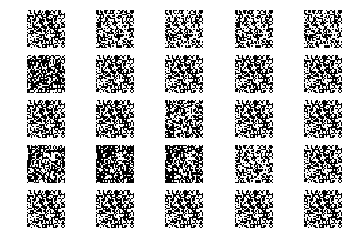

1 [D loss: 2.148485, acc.: 86.52%] [G loss: 4.533215]
2 [D loss: 9.148862, acc.: 43.16%] [G loss: 4.092485]
3 [D loss: 9.522511, acc.: 40.82%] [G loss: 3.903602]
4 [D loss: 10.207536, acc.: 36.52%] [G loss: 3.840640]
5 [D loss: 10.612323, acc.: 33.98%] [G loss: 4.092485]
6 [D loss: 11.951235, acc.: 25.59%] [G loss: 3.526454]
7 [D loss: 10.394361, acc.: 35.35%] [G loss: 2.359562]
8 [D loss: 11.235073, acc.: 30.08%] [G loss: 8.006330]
9 [D loss: 11.639860, acc.: 27.54%] [G loss: 1.385149]
10 [D loss: 12.013510, acc.: 25.20%] [G loss: 0.755536]
11 [D loss: 12.978771, acc.: 19.14%] [G loss: 0.440729]
12 [D loss: 13.669195, acc.: 14.65%] [G loss: 15.551449]
13 [D loss: 1.183224, acc.: 92.58%] [G loss: 15.551449]
14 [D loss: 1.494599, acc.: 90.62%] [G loss: 15.299604]
15 [D loss: 0.840712, acc.: 94.73%] [G loss: 15.551449]
16 [D loss: 0.902987, acc.: 94.34%] [G loss: 15.488488]
17 [D loss: 0.498200, acc.: 96.88%] [G loss: 15.614410]
18 [D loss: 0.311375, acc.: 98.05%] [G loss: 15.299604]
19 

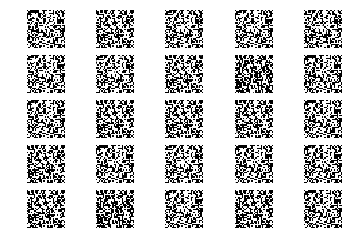

201 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.614410]
202 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
203 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.551449]
204 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
205 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.614410]
206 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.614410]
207 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.614410]
208 [D loss: 8.214738, acc.: 49.02%] [G loss: 15.551449]
209 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.488487]
210 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.677372]
211 [D loss: 8.557250, acc.: 46.88%] [G loss: 15.803295]
212 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.425526]
213 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.551449]
214 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.488487]
215 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
216 [D loss: 8.152463, acc.: 49.41%] [G loss: 15.425526]
217 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.551449]
218 [D loss: 8.245875, acc.: 48

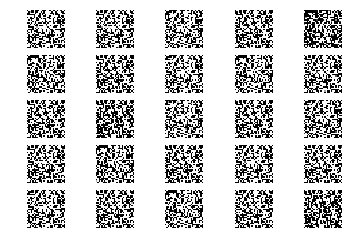

401 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.614410]
402 [D loss: 8.494975, acc.: 47.27%] [G loss: 15.551449]
403 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.551449]
404 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.677372]
405 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
406 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488488]
407 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.614410]
408 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.362565]
409 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
410 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.551449]
411 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.362565]
412 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
413 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.488487]
414 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.362565]
415 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.551449]
416 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.740334]
417 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.614410]
418 [D loss: 8.308150, acc.: 48

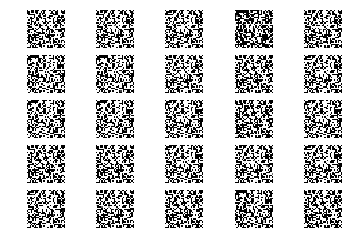

601 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.425527]
602 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.362565]
603 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.551449]
604 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.614410]
605 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.614410]
606 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.614410]
607 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.488488]
608 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.614410]
609 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.425526]
610 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.551449]
611 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.677372]
612 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.614410]
613 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.614410]
614 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.740333]
615 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.614410]
616 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.614410]
617 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.551449]
618 [D loss: 8.090188, acc.: 49

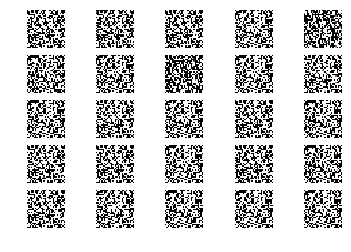

801 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
802 [D loss: 8.681800, acc.: 46.09%] [G loss: 15.614410]
803 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.614410]
804 [D loss: 8.214738, acc.: 49.02%] [G loss: 15.677372]
805 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.551449]
806 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.677372]
807 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.488487]
808 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.740334]
809 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.614410]
810 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.425526]
811 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.362565]
812 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.551449]
813 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.740334]
814 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.677372]
815 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.488487]
816 [D loss: 8.526113, acc.: 47.07%] [G loss: 15.740333]
817 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.488487]
818 [D loss: 8.308150, acc.: 48

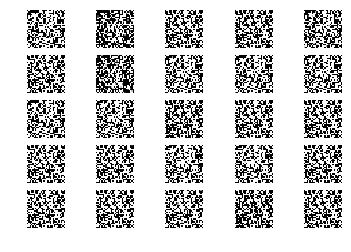

1001 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.803295]
1002 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.677372]
1003 [D loss: 8.121325, acc.: 49.61%] [G loss: 15.614410]
1004 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.551449]
1005 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488488]
1006 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.551449]
1007 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.677372]
1008 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.677372]
1009 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.740334]
1010 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
1011 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.425527]
1012 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.488487]
1013 [D loss: 8.214738, acc.: 49.02%] [G loss: 15.425526]
1014 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.425526]
1015 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.803295]
1016 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.551449]
1017 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.614410]
1018 [D loss: 

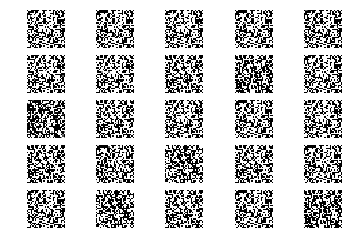

1201 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.488487]
1202 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.614410]
1203 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
1204 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.551449]
1205 [D loss: 8.152463, acc.: 49.41%] [G loss: 15.551449]
1206 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.551449]
1207 [D loss: 8.214738, acc.: 49.02%] [G loss: 15.488488]
1208 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.677372]
1209 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.488487]
1210 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.551449]
1211 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.614410]
1212 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.677372]
1213 [D loss: 8.214738, acc.: 49.02%] [G loss: 15.488487]
1214 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.488488]
1215 [D loss: 8.432700, acc.: 47.66%] [G loss: 15.551449]
1216 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.425526]
1217 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.551449]
1218 [D loss: 

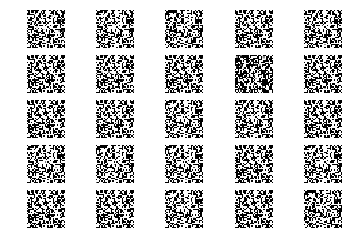

1401 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.551449]
1402 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.425526]
1403 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.677372]
1404 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.677372]
1405 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.551449]
1406 [D loss: 8.557250, acc.: 46.88%] [G loss: 15.551449]
1407 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.425527]
1408 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.425526]
1409 [D loss: 8.494975, acc.: 47.27%] [G loss: 15.614410]
1410 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
1411 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.551449]
1412 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.740334]
1413 [D loss: 8.619525, acc.: 46.48%] [G loss: 15.362565]
1414 [D loss: 8.339288, acc.: 48.24%] [G loss: 15.362565]
1415 [D loss: 8.494975, acc.: 47.27%] [G loss: 15.425526]
1416 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.425526]
1417 [D loss: 8.308150, acc.: 48.44%] [G loss: 15.488487]
1418 [D loss: 

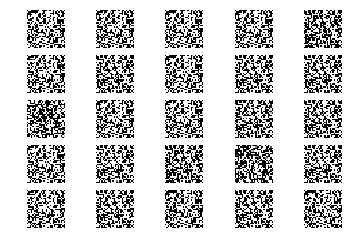

1601 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.551449]
1602 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.488488]
1603 [D loss: 8.463838, acc.: 47.46%] [G loss: 15.425527]
1604 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.425527]
1605 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.425527]
1606 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.677372]
1607 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.677372]
1608 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.740334]
1609 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.362565]
1610 [D loss: 8.401563, acc.: 47.85%] [G loss: 15.488487]
1611 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.803295]
1612 [D loss: 8.183600, acc.: 49.22%] [G loss: 15.299604]
1613 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.488487]
1614 [D loss: 8.277013, acc.: 48.63%] [G loss: 15.425526]
1615 [D loss: 8.370425, acc.: 48.05%] [G loss: 15.740334]
1616 [D loss: 8.152463, acc.: 49.41%] [G loss: 15.488487]
1617 [D loss: 8.245875, acc.: 48.83%] [G loss: 15.803294]
1618 [D loss: 

KeyboardInterrupt: ignored

In [137]:
gen,disc,combined = compileGAN(0.05)
train(epochs=10000, batch_size=256, display_interval=200,generator=gen,discriminator=disc,combined=combined)

### key board interrupted @1800 iteration due to bad results with this learning rate of 0.01 as well as compute restriction

### With learning rate of 0.05 and batch size of 256 the model is not converging to minima instead the Discriminator accuracy is converged at 50 % from 200 to 1000 iteration.

### Lets try reducing learning rate as well as batch size

## 2. Learning rate =0.01 and Batch Size =128





In [135]:
optimizer = Adam(0.01, 0.5)

# Build and compile the discriminator
d = discriminator()
d.compile(loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy'])

# Build the generator
g = generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = g(z)

# For the combined model we will only train the generator
d.trainable = False

# The discriminator takes generated images as input and determines validity
validity = d(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_43 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_295 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_199 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_296 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.526699, acc.: 16.02%] [G loss: 3.076426]


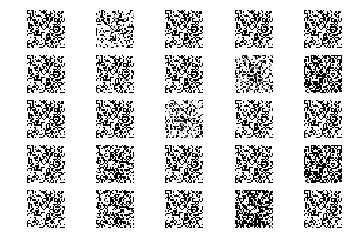

1 [D loss: 5.888061, acc.: 61.33%] [G loss: 7.487830]
2 [D loss: 3.761577, acc.: 76.17%] [G loss: 8.066624]
3 [D loss: 11.052855, acc.: 30.86%] [G loss: 15.079042]
4 [D loss: 8.183634, acc.: 49.22%] [G loss: 14.985205]
5 [D loss: 8.121325, acc.: 49.61%] [G loss: 13.663916]
6 [D loss: 8.264369, acc.: 48.44%] [G loss: 14.049852]
7 [D loss: 8.269877, acc.: 48.44%] [G loss: 15.866255]
8 [D loss: 8.059055, acc.: 50.00%] [G loss: 16.118099]
9 [D loss: 8.060060, acc.: 50.00%] [G loss: 16.118099]
10 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
11 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
12 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
13 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
14 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
15 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
16 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
17 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
18 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
19

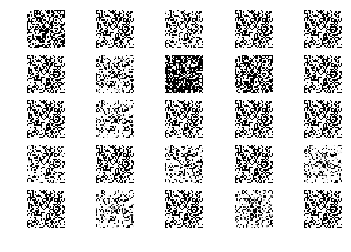

201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
218 [D loss: 8.059050, acc.: 50

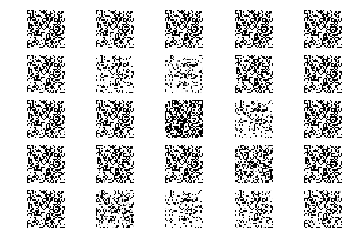

401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
418 [D loss: 8.059050, acc.: 50

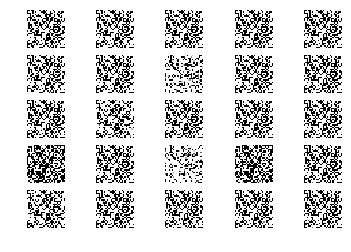

601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
618 [D loss: 8.059050, acc.: 50

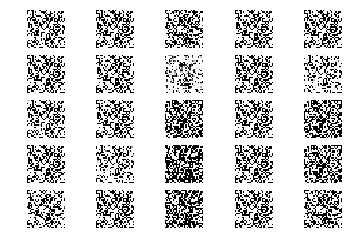

801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
818 [D loss: 8.059050, acc.: 50

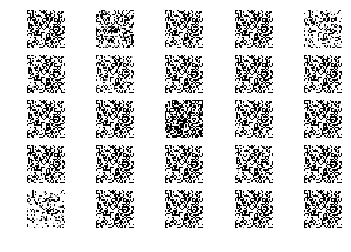

1001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1018 [D loss: 

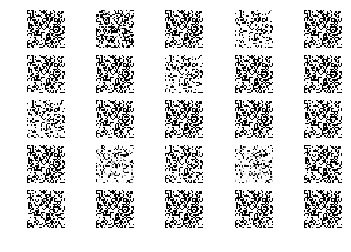

1201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1218 [D loss: 

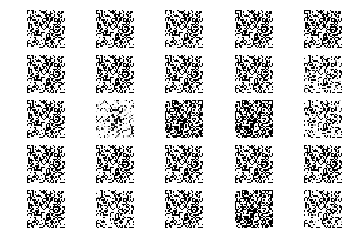

1401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1418 [D loss: 

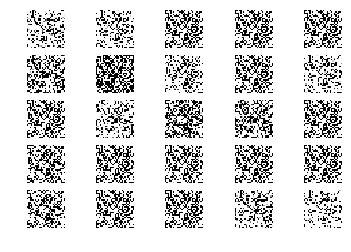

1601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1618 [D loss: 

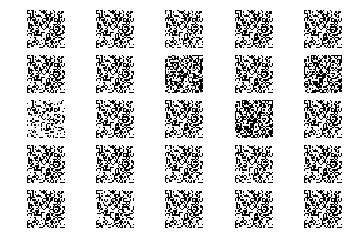

1801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
1818 [D loss: 

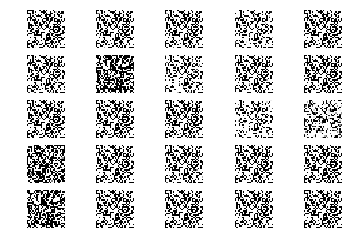

2001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2018 [D loss: 

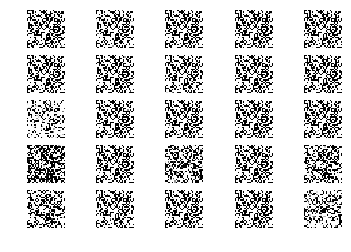

2201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2218 [D loss: 

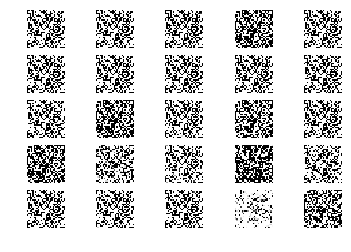

2401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2418 [D loss: 

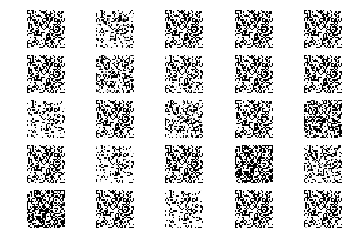

2601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2618 [D loss: 

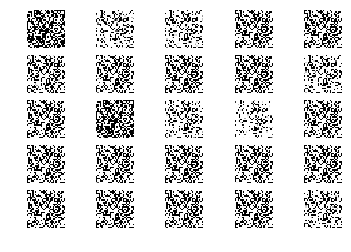

2801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
2818 [D loss: 

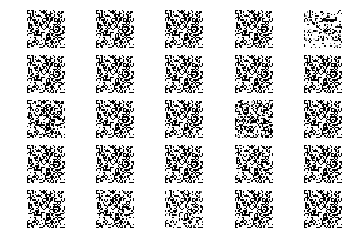

3001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3018 [D loss: 

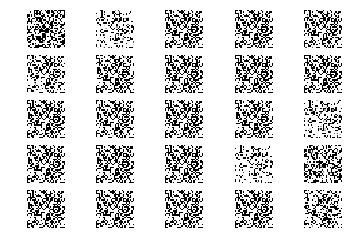

3201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3218 [D loss: 

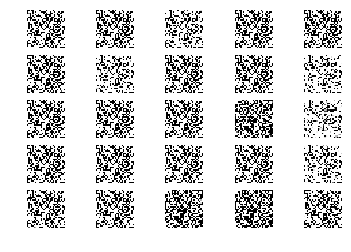

3401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3418 [D loss: 

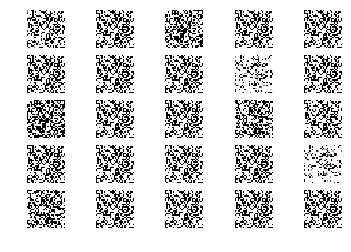

3601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3618 [D loss: 

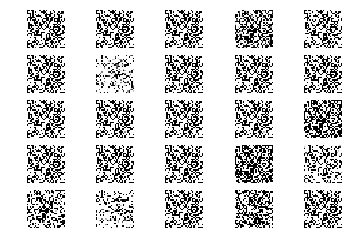

3801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
3818 [D loss: 

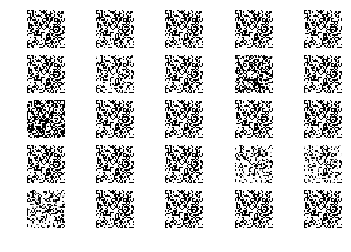

4001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4018 [D loss: 

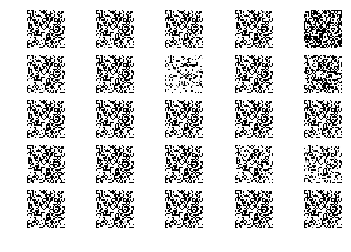

4201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4218 [D loss: 

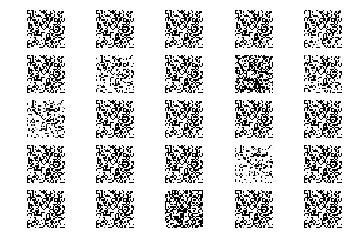

4401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4418 [D loss: 

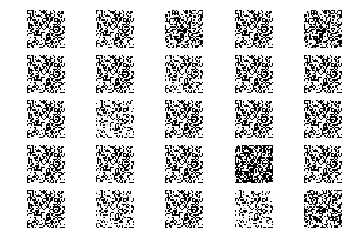

4601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4618 [D loss: 

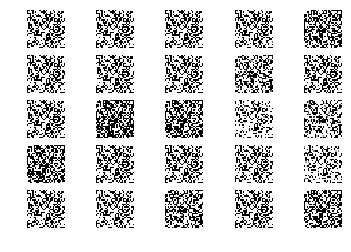

4801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
4818 [D loss: 

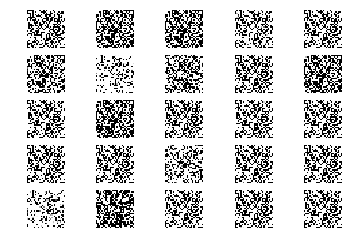

5001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5018 [D loss: 

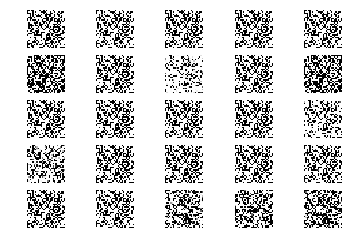

5201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5218 [D loss: 

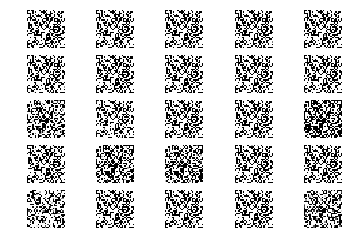

5401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5418 [D loss: 

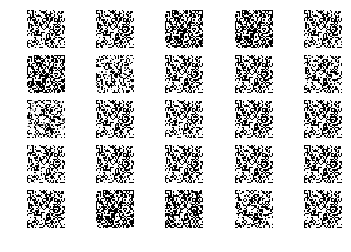

5601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5618 [D loss: 

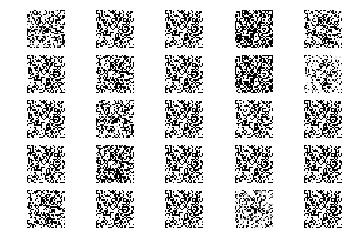

5801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
5818 [D loss: 

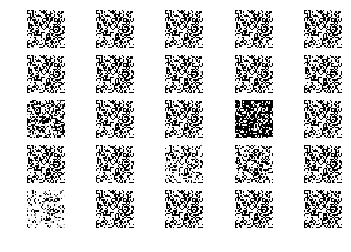

6001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6018 [D loss: 

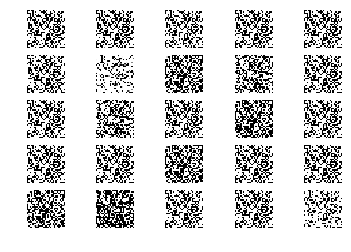

6201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6218 [D loss: 

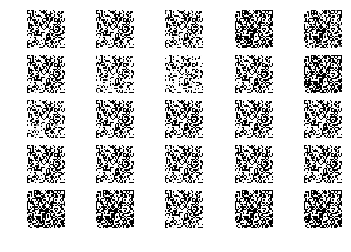

6401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6418 [D loss: 

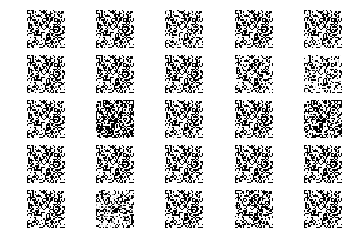

6601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6618 [D loss: 

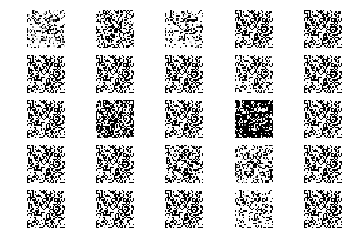

6801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
6818 [D loss: 

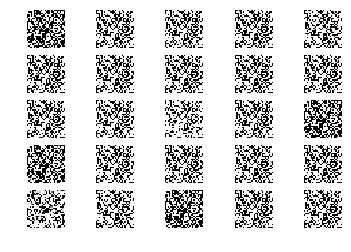

7001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7018 [D loss: 

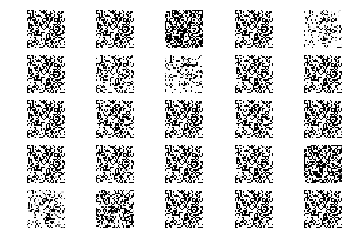

7201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7218 [D loss: 

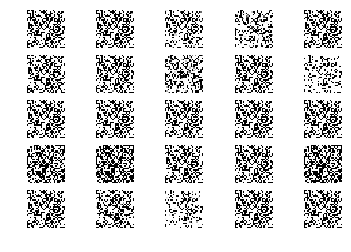

7401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7418 [D loss: 

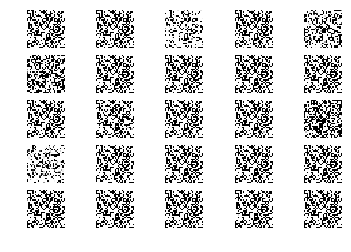

7601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7618 [D loss: 

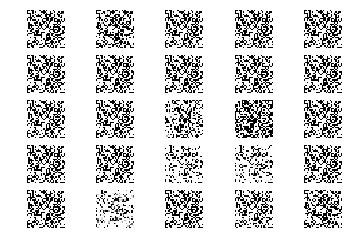

7801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
7818 [D loss: 

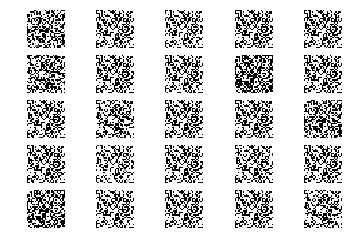

8001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8018 [D loss: 

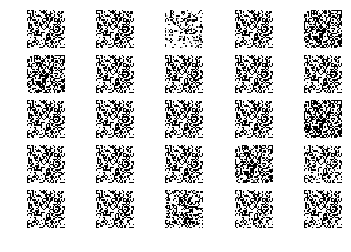

8201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8218 [D loss: 

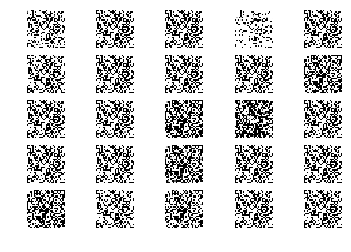

8401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8418 [D loss: 

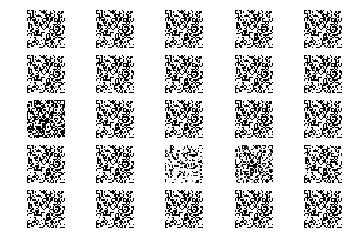

8601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8618 [D loss: 

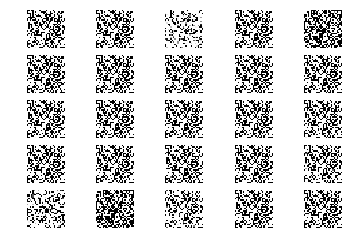

8801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
8818 [D loss: 

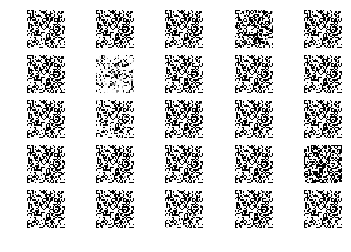

9001 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9002 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9003 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9004 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9005 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9006 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9007 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9008 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9009 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9010 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9011 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9012 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9013 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9014 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9015 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9016 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9017 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9018 [D loss: 

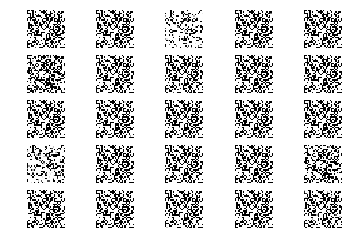

9201 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9202 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9203 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9204 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9205 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9206 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9207 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9208 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9209 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9210 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9211 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9212 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9213 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9214 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9215 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9216 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9217 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9218 [D loss: 

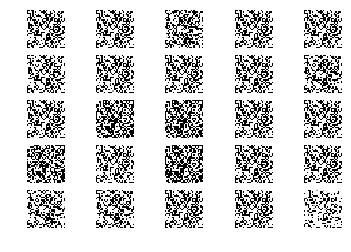

9401 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9402 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9403 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9404 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9405 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9406 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9407 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9408 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9409 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9410 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9411 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9412 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9413 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9414 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9415 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9416 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9417 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9418 [D loss: 

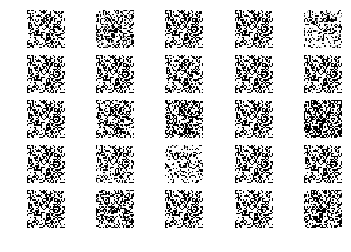

9601 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9602 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9603 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9604 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9605 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9606 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9607 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9608 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9609 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9610 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9611 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9612 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9613 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9614 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9615 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9616 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9617 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9618 [D loss: 

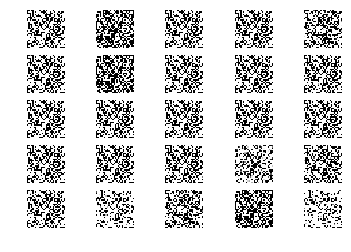

9801 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9802 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9803 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9804 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9805 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9806 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9807 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9808 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9809 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9810 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9811 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9812 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9813 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9814 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9815 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9816 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9817 [D loss: 8.059050, acc.: 50.00%] [G loss: 16.118099]
9818 [D loss: 

In [136]:
#gen,disc,combined = compileGAN(0.01)
train(epochs=10000, batch_size=128, display_interval=200,generator=g,discriminator=d,combined=combined)

## Inference

### With learning rate of 0.01 or 0.02 GAN is not generating good generated images and is not getting converged.

### Very small update like learning rate as 0.0002 and iteration morethan 30000 would generate better mnist images but due to compute restriction we havent run 30000 iteration